# Expression Cloning

In [1]:
import igl
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter
from scipy.sparse import  diags
from scipy.sparse.linalg import spsolve

import torch
import torch.nn as nn
import torch.optim
from tqdm import tqdm


In [321]:
def get_vertex_to_face_map(V, F):
    """
    For each vertex, returns a list of face indices it belongs to.

    Args:
        V (np.ndarray): Vertices array of shape (n, 3)
        F (np.ndarray): Faces array of shape (m, 3)

    Returns:
        vertex_face_map (list of lists): vertex_face_map[i] contains the list of face indices that vertex i belongs to
    """
    num_vertices = V.shape[0]
    vertex_face_map = [[] for _ in range(num_vertices)]

    for face_idx, face in enumerate(F):
        for vertex_idx in face:
            vertex_face_map[vertex_idx].append(face_idx)

    return vertex_face_map

def get_TBN_foreach_vertex(V, F):
    """
    Get TBN matrix for each vertex

    Args:
        V (np.ndarray): vertices (N, 3)
        F (np.ndarray): faces / trianlges (M, 3)

    Returns:
        np.ndarray: matrix (N, 3, 3)
        [
            [Tx, Ty, Tz],
            [Bx, By, Bz],
            [Nx, Ny, Nz],
        ]
    """
    Vn = igl.per_vertex_normals(V, F)
    
    al = igl.adjacency_list(F) # all neighbors
    nb = [nbrs[0] for nbrs in al] # select one
    
    Vt_nb = V[nb] - V
    Vt_nb = Vt_nb/(np.linalg.norm(Vt_nb, axis=1)[:,None]+1e-8)

    # project
    _Vt = np.sum(Vt_nb * Vn, axis=1, keepdims=True)
        
    Vt = Vt_nb - (_Vt * Vn)
    Vt = Vt/(np.linalg.norm(Vt, axis=1, keepdims=True)+1e-8)
    
    Vb = np.cross(Vn, Vt)
    Vb = Vb/(np.linalg.norm(Vb, axis=1, keepdims=True)+1e-8)
    
    return np.concatenate([
        Vt[:,None], 
        Vb[:,None],
        Vn[:,None], 
    ], axis=1)

def rescale(V1 ,V2):
    """rescale V1 to V2"""
    V1mean = (V1.max(0)+V1.min(0))*0.5
    V2mean = (V2.max(0)+V2.min(0))*0.5
    V = (V1-V1mean)/max(V1.max(0)-V1.min(0)) * max(V2.max(0)-V2.min(0)) + V2mean
    return V

def get_TriangleArea_foreach_vertex(V,F):
    """
    Returns (V,)
    """
    DArea = igl.doublearea(V, F) * 0.5
    print(DArea.shape)

    V2F = get_vertex_to_face_map(V,F)
    VArea = []
    for v2f in V2F:
        VArea.append(np.sum(DArea[v2f])/len(v2f))
    VArea = np.array(VArea)
    return VArea

def get_scale_foreach_vertex(V,F):
    """
    Returns (V, 3)
    """
    # Vxyz = []
    # for vf in V[F]: # F, 3, 3
    #     Vxyz.append(vf.max(0)-vf.min(0))
    # Vxyz = np.array(Vxyz)
    
    V2F = get_vertex_to_face_map(V,F)
    Vscale = []
    for v2f in V2F:
        Vscale.append(np.std(V[F[v2f]].reshape(-1,3), axis=0))
    Vscale = np.array(Vscale)
    return Vscale

# def get_scale_foreach_triangle(Vsrc, Vdef, Fsrc):
#     """
#     get scale ratio of DeformedSourceModelLocalBoudingBox / SourceModelLocalBoudingBox
#     Returns (V, 3, 3)
#     """
#     S_matrices = np.zeros((Vsrc.shape[0], 3))

#     all_nbh = igl.adjacency_list(Fsrc) # all neighbors for each vertex    
#     for v_idx, nbh in enumerate(all_nbh):

#         # get positions in both source and deformed meshes
#         local_src = Vsrc[nbh]
#         local_def = Vdef[nbh]

#         # bounding box: max - min
#         bbox_src = np.max(local_src, axis=0) - np.min(local_src, axis=0)
#         bbox_def = np.max(local_def, axis=0) - np.min(local_def, axis=0)

#         # prevent divide by zero
#         bbox_src[bbox_src == 0] = 1e-8

#         scale = bbox_def / bbox_src  # (3,)
#         S_matrices[v_idx] = scale

#     return S_matrices

def get_scale_foreach_triangle(Vsrc, Fsrc):
    """
    get scale ratio of DeformedSourceModelLocalBoudingBox / SourceModelLocalBoudingBox
    Returns (V, 3, 3)
    """
    S_matrices = np.zeros((Vsrc.shape[0], 3))

    all_nbh = igl.adjacency_list(Fsrc) # all neighbors for each vertex    
    for v_idx, nbh in enumerate(all_nbh):

        # get positions in both source and deformed meshes
        local_src = Vsrc[nbh]

        # bounding box: max - min
        bbox_src = np.max(local_src, axis=0) - np.min(local_src, axis=0)

        # prevent divide by zero
        bbox_src[bbox_src == 0] = 1e-8

        S_matrices[v_idx] = bbox_src

    return S_matrices

def smooth(vert, lap, loop=1, t=0.01):
    D_Inv = diags(1 / lap.diagonal())
    _lap = D_Inv @ lap
    
    # a = 1-t
    I_L = scipy.sparse.identity(lap.shape[0]) - _lap*t
    # I_L = (I_L*t).power(loop)
    for i in range(loop):
        I_L = I_L.T @ I_L
    
    vert = I_L @ vert
    return vert

def taubin_smooth(vert, lap, values, loop=2, m=0.01, l=0.01):
    D_Inv = diags(1 / lap.diagonal())
    _lap = D_Inv @ lap
    
    I_L = scipy.sparse.identity(lap.shape[0]) - _lap*l
    I_M = scipy.sparse.identity(lap.shape[0]) - _lap*m
    
    I_L = I_L @ I_M
    for i in range(loop-1):
        I_L = I_L @ I_L
    
    values = I_L @ values
    return values

def mesh_smooth(V, F, values, tau=0.001):

    # Mesh smoothing with libigl
    l = igl.cotmatrix(V, F)  # laplace-beltrami operator in libigl
    m = igl.massmatrix(V, F, igl.MASSMATRIX_TYPE_BARYCENTRIC) # mass matrix in libigl
    s = m - tau * l
    return spsolve(s, m @ values)

def random_rotation_matrix(randgen=None):
    """
    Borrowed from https://github.com/nmwsharp/diffusion-net/blob/master/src/diffusion_net/utils.py
    
    Creates a random rotation matrix.
    randgen: if given, a np.random.RandomState instance used for random numbers (for reproducibility)
    """
    # adapted from http://www.realtimerendering.com/resources/GraphicsGems/gemsiii/rand_rotation.c
    
    if randgen is None:
        randgen = np.random.RandomState()
        
    theta, phi, z = tuple(randgen.rand(3).tolist())
    
    theta = theta * 2.0*np.pi  # Rotation about the pole (Z).
    phi = phi * 2.0*np.pi  # For direction of pole deflection.
    z = z * 2.0 # For magnitude of pole deflection.
    
    # Compute a vector V used for distributing points over the sphere
    # via the reflection I - V Transpose(V).  This formulation of V
    # will guarantee that if x[1] and x[2] are uniformly distributed,
    # the reflected points will be uniform on the sphere.  Note that V
    # has length sqrt(2) to eliminate the 2 in the Householder matrix.
    
    r = np.sqrt(z)
    Vx, Vy, Vz = V = (
        np.sin(phi) * r,
        np.cos(phi) * r,
        np.sqrt(2.0 - z)
        )
    
    st = np.sin(theta)
    ct = np.cos(theta)
    
    R = np.array(((ct, st, 0), (-st, ct, 0), (0, 0, 1)))
    # Construct the rotation matrix  ( V Transpose(V) - I ) R.

    M = (np.outer(V, V) - np.eye(3)).dot(R)
    return M
    
def random_rotate_points(pts, randgen=None, return_rot=False):
    R = random_rotation_matrix(randgen) 
    if return_rot:
        return np.matmul(pts, R), R
    return np.matmul(pts, R)


## create mesh set

In [322]:
from utils.ict_face_model import ICT_face_model
ict = ICT_face_model()
import pickle

with open('corr_vertex_bc_src2tgt.pkl', 'rb') as f:
    corr_src2tgt_bc = pickle.load(f)
    
with open('corr_vertex_bc_tgt2src.pkl', 'rb') as f:
    corr_tgt2src_bc = pickle.load(f)
    
V, F = igl.read_triangle_mesh("data/source_restpose_mesh.obj")
V_, F_ = igl.read_triangle_mesh("data/source_fitted_mesh.obj")
# V_, F_ = igl.read_triangle_mesh("data/ict_orig_100_trimesh.obj")

# newV, newF = igl.read_triangle_mesh("data/m02_deformed-0.2.obj")
newV, newF = igl.read_triangle_mesh("data/target_restpose_mesh.obj")
## Note that both mesh has same mesh structure! -> F == newF
newV = rescale(newV ,V)
R = np.eye(3)
M_SCALE=3
M_DESCALE=1/M_SCALE
trns = np.array([0,0,0])
newV = newV*M_SCALE
# newV, R = random_rotate_points(newV * M_SCALE,return_rot=True)
newV = newV+trns
V_ = np.matmul(V_, R) * M_SCALE + trns

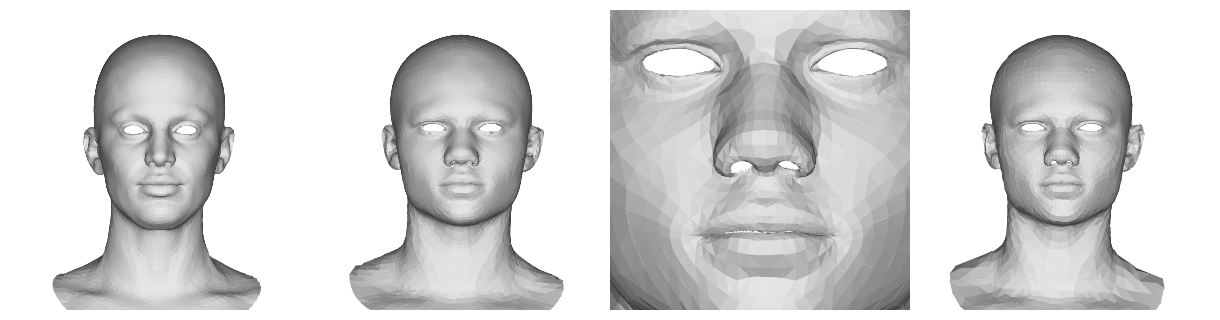

In [323]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = 0.6
# mesh that you wanna render
FRAME=150
v_list=[ V, np.matmul(V_,R.T)*M_DESCALE, newV, np.matmul(newV,R.T)*M_DESCALE ]
v_list=[ v*mesh_scale for v in v_list]
# f_list=[ F ]*len(v_list)
f_list=[ F, F_, newF, newF ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

## Animation for the source mesh

In [324]:
# motions = np.load(r'_tmp\040.npy')
# print(motions.shape)

blendshapes = ict.exp_basis[:,:11248]
BS = 26
BS1 = 26
BS2=5

# motions = np.load(r'_tmp\040.npy')
# displacements = motions - V[None]
# tmpv, tmpf = igl.read_triangle_mesh("data/source_deformed_mesh.obj")
# displacements = blendshapes[BS1]+blendshapes[BS2]
displacements = blendshapes[[26,5,11]].sum(0)
# displacements = tmpv - V
print(displacements.shape, displacements.max())

(11248, 3) 0.083766006


## Get local coordinate system via TBN matrix

In [325]:
# V_tgt = (V[F[corr_src2tgt_bc[0]]]*(corr_src2tgt_bc[1][...,None])).sum(1)
V_TBN = get_TBN_foreach_vertex(V, F)
# V_TBN = get_TBN_foreach_vertex(V_tgt, newF)

# corr_newV = (newV[newF[corr_tgt2src_bc[0]]]*(corr_tgt2src_bc[1][...,None])).sum(1)
# newV_TBN = get_TBN_foreach_vertex(corr_newV, F)
# newV = (V[F[corr_src2tgt_bc[0]]]*(corr_src2tgt_bc[1][...,None])).sum(1)
# newV_TBN = get_TBN_foreach_vertex(newV, newF)
newV_TBN = get_TBN_foreach_vertex(V_, F_)


print(V_TBN.shape, V_TBN.min(), V_TBN.max())
print(newV_TBN.shape, newV_TBN.min(), newV_TBN.max())

(11248, 3, 3) -0.9999952973419544 0.9999996923988467
(11248, 3, 3) -0.9999946713950568 0.9999623909472237


## Scale using BB

In [326]:
# Vs = get_scale_foreach_vertex(V, F)
# newVs = get_scale_foreach_vertex(newV, F)
# newS = newVs/Vs
# newS_src = get_scale_foreach_triangle(V, F)
# newS_def = get_scale_foreach_triangle(np.matmul(newV, R.T), F)


newS_src = get_scale_foreach_triangle(V, F)
# newS_def = get_scale_foreach_triangle(V_, F_)
# newS = newS_def / newS_src
newS_def = get_scale_foreach_triangle(np.matmul(newV, R.T), newF)
corr_newS_def = (newS_def[newF[corr_tgt2src_bc[0]]]*(corr_tgt2src_bc[1][...,None])).sum(1)
newS = corr_newS_def / newS_src

    
newS = gaussian_filter(newS, 5, mode='nearest')

# Lap = igl.cotmatrix(V, F)
# newS = smooth(newS, Lap, loop=2, t=0.03)

newS = mesh_smooth(V, F, newS, tau=0.1)
# newS[:,0] = gaussian_filter1d(newS[:,0], 3,mode='nearest')
# newS[:,1] = gaussian_filter1d(newS[:,1], 3,mode='nearest')
# newS[:,2] = gaussian_filter1d(newS[:,2], 3,mode='nearest')

# max_std = newS.std(0)*3
# for i in range(3):
#     tmp = newS[:, i]
#     tmp[tmp > max_std[i]] = max_std[i]
#     newS[:, i] = tmp

# newS = newS @ np.eye(3)
newS = np.eye(3)[None,:,:] * newS[:,:,None]
print(newS.shape, newS.min(), newS.max())

(11248, 3, 3) 0.0 6.841164006563809


## Animation with Motion Vectors

In [327]:
# MAT = newS * np.einsum('bcn, bnk->bck', newV_TBN.transpose(0,2,1), V_TBN)
MAT = np.einsum('bcn, bnk->bck', newV_TBN.transpose(0,2,1), V_TBN)
# MAT = np.einsum('bcn, bnk->bck', newS, MAT)


new_displacements_ = np.einsum('bck, bk->bc', MAT, displacements)
new_displacements_ = mesh_smooth(V, F, new_displacements_, tau=0.01)

new_displacements = (new_displacements_[F[corr_src2tgt_bc[0]]]*(corr_src2tgt_bc[1][...,None])).sum(1)
# new_displacements = (new_displacements[F[corr_src2tgt_bc[0]]]).mean(1)

## filtering...
new_displacements = mesh_smooth(newV, newF, new_displacements, tau=0.01)



# lap = igl.cotmatrix(V, F)
# new_displacements = smooth(displacements, lap, loop=3, t=0.01)
print(new_displacements.shape, new_displacements.min(), new_displacements.max())

(3694, 3) -0.2892851418136169 0.0473931768369572


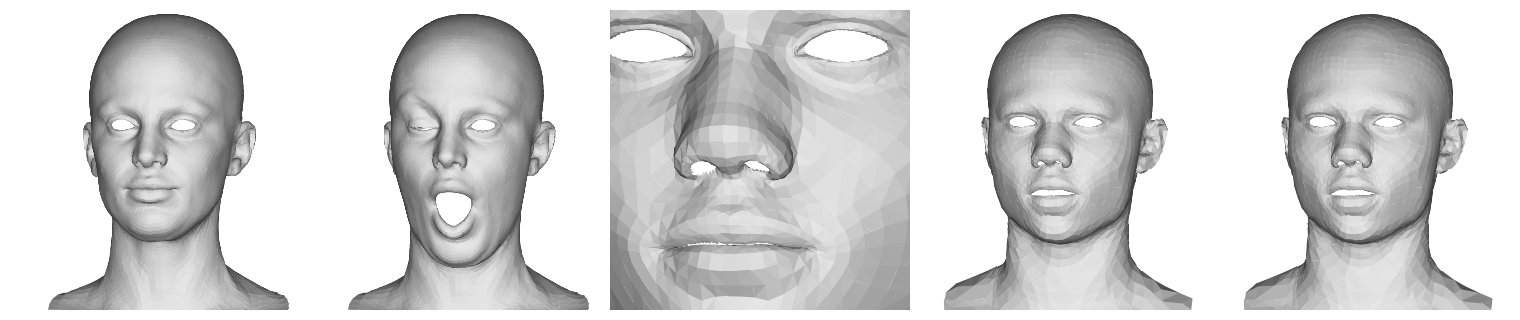

In [328]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .7
mesh_trans = np.array([0,0,0])
# mesh that you wanna render

v_list=[ V, displacements+V, 
        # np.matmul(newV, R.T)*M_DESCALE, 
        newV, 
        # np.matmul(new_displacements_*1.8+V_, R.T)*M_DESCALE, 
        np.matmul(new_displacements+newV, R.T)*M_DESCALE-trns, 
        (new_displacements+newV)*M_DESCALE-trns
       ]
v_list=[ v*mesh_scale+mesh_trans for v in v_list ]
f_list=[ F, F, newF, 
        # F, 
        newF, newF ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,-10,0] ]*len(v_list)

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

[000000] loss: 5.400e-01:   0%|          | 0/5000 [00:00<?, ?it/s]

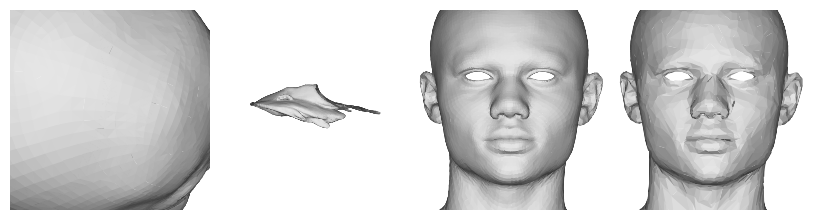

[001000] loss: 3.206e-04:  20%|█▉        | 999/5000 [01:46<07:16,  9.16it/s]

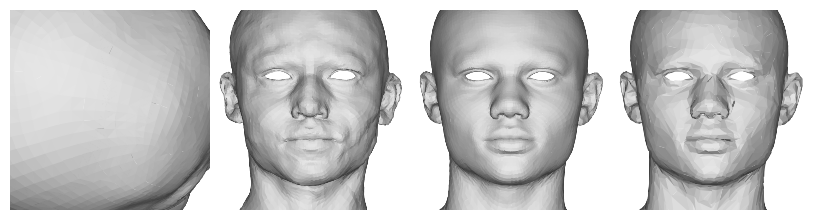

[002000] loss: 2.868e-04:  40%|████      | 2000/5000 [03:31<05:29,  9.11it/s]

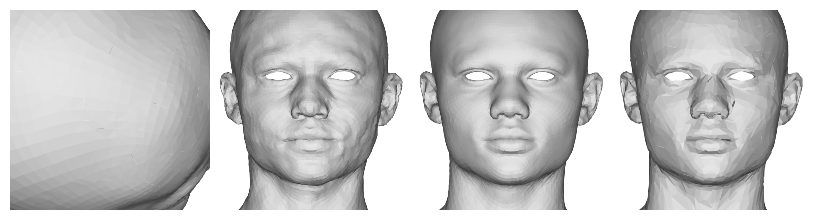

[003000] loss: 2.530e-04:  60%|██████    | 3000/5000 [05:16<03:38,  9.15it/s]

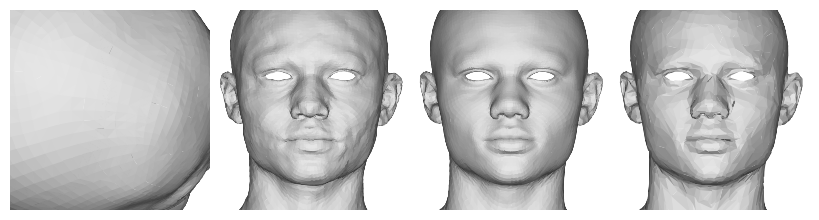

[004000] loss: 2.606e-04:  80%|████████  | 4000/5000 [07:01<01:43,  9.62it/s]

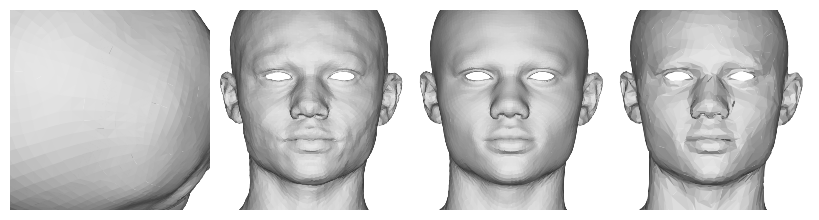

[004999] loss: 2.664e-04: 100%|██████████| 5000/5000 [08:46<00:00,  9.49it/s]


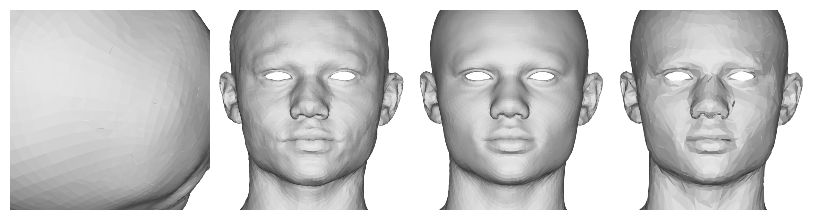

In [362]:
V, F = igl.read_triangle_mesh(r"data/source_restpose_mesh.obj")

SIZE=2
lr = 3e-3


device='cuda'
# model = Model(3)
model = Model(3+3)
optimizer = torch.optim.Adam([*model.parameters()], lr=lr, betas=(0.9, 0.999))
criterion = nn.MSELoss()
# criterion = ChamferDistance()

batch_size = 2

base_coord = torch.tensor(id_tmp)[None].float()
base_faces = torch.tensor(F).long()
# gt_vert = torch.tensor(tmp_trimesh.vertices).float()
# gt_faces = torch.tensor(tmp_trimesh.faces).long()
gt_vert = torch.tensor(id_tmp[ict_decimate['v_idx']]).float()
gt_face = torch.tensor(ict_decimate['new_f']).long()

N = base_coord.shape[1]

dummy_ones = torch.ones_like(ID_code[:,None]).to(device)


num_iter=5_000
pbar = tqdm(range(num_iter))
model.to(device)
model.train()
for i in pbar:
    
    V_th = base_coord.repeat(batch_size, 1, 1)

    id_vert_ = torch.cat([id_vert.to(device), V_th.to(device)], dim=-1)
    
    w = model(id_vert_.to(device), dummy_ones).reshape(batch_size, N, 3, 3)
    v_pred = torch.einsum('bnck,bnk->bnc', w, id_vert.to(device))

    # displacement
    displacements = ict.get_exp_disp(np.random.rand(batch_size, 53)) # [1, N, 3]
    displacements = torch.tensor(displacements).float().to(device)
    
    V_th_exp = V_th.to(device) + displacements

    #disp_pred = torch.einsum('bnck,bnk->bnc', w, displacements)
    v_pred_exp = v_pred + displacements

    
    if i < num_iter:
        loss = criterion(V_th.to(device), v_pred)
        loss += criterion(V_th_exp, v_pred_exp)
        
        p3d_mesh_0 = Meshes(verts=[v for v in v_pred], faces=[base_faces.to(device)]*batch_size)
        # loss_lap = mesh_laplacian_smoothing(p3d_mesh_0, method='cot')
        # loss = loss+loss_lap*0.1

        loss_edge = mesh_edge_loss(p3d_mesh_0)
        loss = loss+loss_edge*0.1
    else:
        loss_v = criterion(V_th.to(device)[:, ict_decimate['v_idx']], v_pred[:, ict_decimate['v_idx']])
        
        p3d_mesh = Meshes(verts=[gt_vert.to(device)]*batch_size, faces=[gt_face.to(device)]*batch_size)
        p3d_cld = Pointclouds(points=v_pred)        
        loss_p2m = point_mesh_face_distance(p3d_mesh, p3d_cld)
        
        p3d_mesh_2 = Meshes(verts=[v for v in v_pred], faces=[base_faces.to(device)]*batch_size)
        p3d_cld_2 = Pointclouds(points=[gt_vert.to(device)]*batch_size)        
        loss_p2m_2 = point_mesh_face_distance(p3d_mesh_2, p3d_cld_2)

        loss_lap = mesh_laplacian_smoothing(p3d_mesh, method='cot')
        loss_lap_2 = mesh_laplacian_smoothing(p3d_mesh_2, method='cot')
        
        # select = torch.randint(gt_vert.shape[0],(gt_vert.shape[0],))
        # v_pred_sample = v_pred[:, select]
        # loss_chamfer, _ = chamfer_distance(v_pred_sample, gt_vert.to(device)[None].repeat(batch_size,1,1))
        loss = loss_p2m +loss_p2m_2 + (loss_lap+loss_lap_2)*0.1
    # loss = criterion(gt_vert.to(device).repeat(batch_size, 1, 1), v_pred, bidirectional=False)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    pbar.set_description(f"[{i:06d}] loss: {loss.item():.3e}")

    if i % 1000 == 0:
        v_list=[ id_vert[0], v_pred[0].detach().cpu().numpy(), V_th[0], gt_vert]
        v_list=[ v  for v in v_list ]
        f_list=[ F, F, F, gt_face ]

        # xyz Euler angle to rotate the mesh
        rot_list=[ [0,0,0] ]*len(v_list)
        plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

v_list=[ id_vert[0], v_pred[0].detach().cpu().numpy(), V_th[0], gt_vert ]
v_list=[ v  for v in v_list ]
f_list=[ F, F, F, gt_face ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')


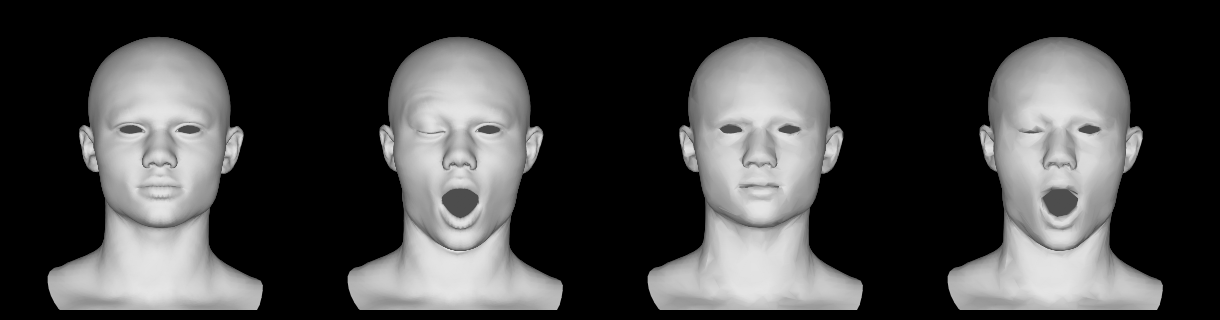

In [329]:
base_coord = torch.tensor(id_tmp)[None].float()
vertex_map = ict_decimate['v_idx']

blendshapes = ict.exp_basis[:,:11248]
BS1 = 26
BS2 = 5
BS_S = np.array([26, 5, 11])
displacements = blendshapes[BS_S].sum(0)
displacements_mapped = displacements[vertex_map]#.mean(-2)

SIZE=3
v_list=[
    base_coord[0].detach().numpy(),
    (displacements+base_coord[0].detach().numpy()),
    # (displacements+base_coord[0].detach().numpy()) @ R0.T @ R0.T,
    id_tmp[ict_decimate['v_idx']],
    displacements_mapped+id_tmp[ict_decimate['v_idx']],
]
v_list=[ v for v in v_list ]
f_list=[ F, F, gt_face, gt_face ]
# vn_list = [
#     base_vn[0].detach().numpy(),
#     base_vn[0].detach().numpy(),
#     gt_vn.detach().numpy(),
#     gt_vn.detach().numpy(),
# ]
# vn_list=[ vn*0.5+0.5 for vn in vn_list ]
# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')
plot_mesh_gouraud(v_list, f_list, 
                  # Cs=vn_list, is_color=True,
                  rot_list=rot_list, size=SIZE, mode='shade', mesh_scale=.6)

/tmp/ipykernel_91621/3655992594.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_coord = torch.tensor(id_vert).float()


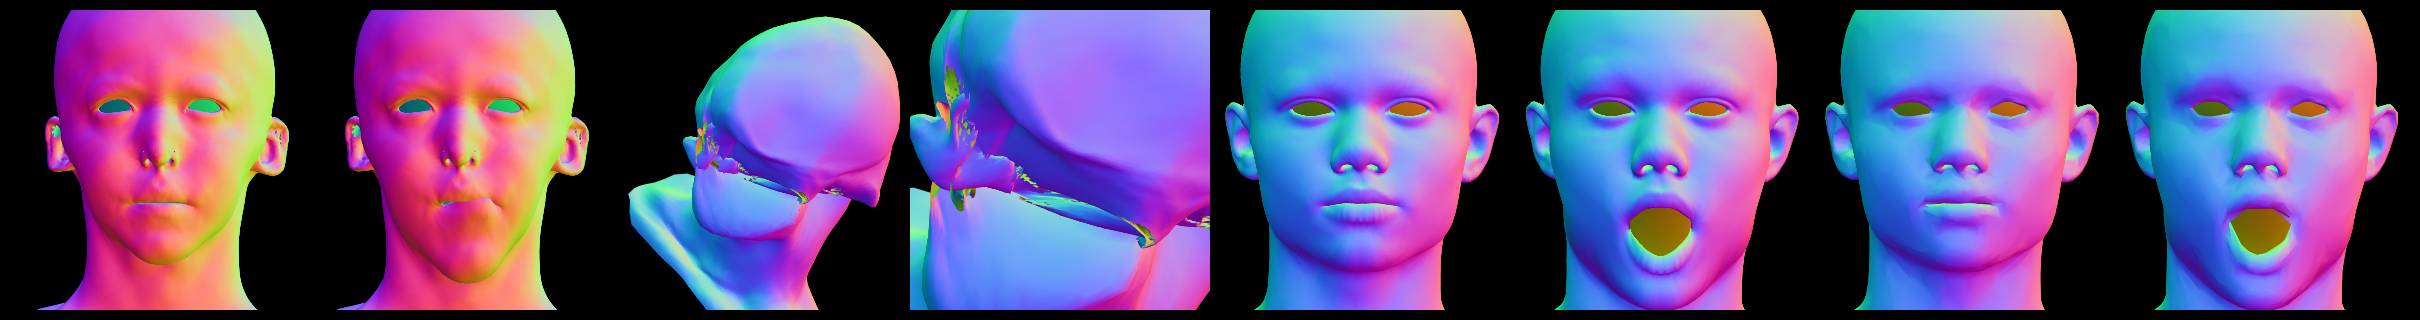

In [351]:
model.eval()
# base_coord = torch.tensor(ict.neutral_verts)[None].float()

# displacements = ict.get_exp_disp(np.random.rand(1,53)) # [1, N, 3]
blendshapes = ict.exp_basis[:,:11248]
BS1 = 26
BS2 = 5
displacements = blendshapes[BS1]+blendshapes[BS2]
#displacements = displacements @ R0

base_coord = torch.tensor(id_tmp)[None].float()
# tgt_vert = torch.tensor(tmp_trimesh.vertices)[None].float()
vertex_map = ict_decimate['v_idx']
tgt_vert = torch.tensor(id_tmp[ict_decimate['v_idx']]).float()[None]
gt_face = torch.tensor(ict_decimate['new_f']).long()
gt_vn = torch.tensor(calc_norm_trimesh(id_tmp[ict_decimate['v_idx']], ict_decimate['new_f'])[0]).float()

in_coord = torch.tensor(id_vert).float()
in_vn = torch.tensor([calc_norm_trimesh(id_v.numpy(), F)[0] for id_v in id_vert]).float()
base_vn = torch.tensor(calc_norm_trimesh(base_coord[0], F)[0])[None].float()

in_vn_mapped = in_vn[:, vertex_map]

rp = torch.randperm(id_vert.shape[1])
rp_inv=torch.argsort(rp)

batch_size=2
N = id_vert.shape[1]

dummy_ones = torch.ones_like(ID_code[:,None]).to(device)
# V_th1 = id_vert.repeat(batch_size, 1, 1)
# V_th1 = V_th1[:, rp]

id_vert_ = torch.cat([id_vert.to(device), base_coord.to(device).repeat(batch_size, 1, 1)], dim=-1)
w1 = model(id_vert_, dummy_ones).reshape(batch_size,N,3,3)


v_trns1 = torch.einsum('bnck,bnk->bnc', w1, id_vert.to(device)).cpu().detach()
v_trns1_vn = torch.tensor([calc_norm_trimesh(v_t.numpy(), F)[0] for v_t in v_trns1]).float()

# new_disp1 = torch.einsum('bnck,nk->bnc', w1, torch.tensor(displacements).float().to(device) ).cpu().detach()
new_disp1 = torch.tensor(displacements).float()
pred_new_disp1 = torch.einsum('bnkc,nk->bnc', w1, torch.tensor(displacements).float().to(device) ).cpu().detach()
pred_vn = torch.einsum('bnkc,nk->bnc', w1, base_vn[0].to(device) ).cpu().detach()

M=vertex_map.shape[0]
in_mapped = id_vert[:, vertex_map]#.mean(-2)
base_mapped = base_coord[:,vertex_map]#.mean(-2)
base_mapped = base_mapped.repeat(batch_size, 1, 1)
in_mapped_ = torch.cat([in_mapped.to(device), base_mapped.to(device)], dim=-1)

w2 = model(in_mapped_, ID_code[:, None].to(device)).reshape(batch_size,M,3,3)

displacements_mapped = displacements[vertex_map]#.mean(-2)
# new_disp2 = torch.einsum('bnck,nk->bnc', w2, torch.tensor(displacements_mapped).float().to(device) ).cpu().detach()
new_disp2 = torch.tensor(displacements_mapped).float()
# new_disp2 = torch.einsum('bnkc,nk->bnc', w2, torch.tensor(displacements_mapped).float().to(device) ).cpu().detach()


# R0_np = R0.detach().cpu().numpy()
v_list=[ 
    # id_vert[0].detach().numpy(),
    np.matmul(id_vert[0].detach().cpu().numpy(), R0.T) * M_DESCALE,
    # displacements+id_vert[0].detach().numpy(),
    # (pred_new_disp1[0]+id_vert[0]).detach().numpy(),
    np.matmul((pred_new_disp1[0]+id_vert[0]).detach().cpu().numpy(), R0.T) * M_DESCALE,
    v_trns1[0].detach().numpy(),
    (new_disp1+v_trns1)[0].detach().numpy(),
    base_coord[0].detach().numpy(),
    (new_disp1+base_coord)[0].detach().numpy(),
    # optim_coord[0].detach().cpu(),
    # (new_disp2+optim_coord.detach().cpu())[0],
    tgt_vert[0].detach().numpy(),
    (new_disp2+tgt_vert)[0].detach().numpy(),
]
# v_list=[ id_vert[0].detach().numpy(), id_disp[0]+id_vert[0].detach().numpy()]
v_list=[ v for v in v_list ]
f_list=[ F, F, F, F, F, F, gt_face, gt_face ]
# vn_list = [ calc_norm_trimesh(vertices, faces)[0] for vertices, faces in zip(v_list, f_list)]
vn_list = [
    in_vn[0].detach().numpy(),
    in_vn[0].detach().numpy(),
    # np.matmul(in_vn[0].detach().cpu().numpy(), R0.T),
    # np.matmul(in_vn[0].detach().cpu().numpy(), R0.T),
    # pred_vn[0].detach().numpy(),
    # base_vn[0].detach().numpy(),
    # pred_vn[0].detach().numpy(),
    v_trns1_vn[0].detach().numpy(),
    v_trns1_vn[0].detach().numpy(),
    base_vn[0].detach().numpy(),
    base_vn[0].detach().numpy(),
    gt_vn.detach().numpy(),
    gt_vn.detach().numpy(),
]
vn_list=[ vn*0.5+0.5 for vn in vn_list ]
# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')
plot_mesh_gouraud(v_list, f_list, 
                  Cs=vn_list, is_color=True,
                  rot_list=rot_list, size=SIZE, mode='shade')

In [72]:
%load_ext autoreload
%autoreload 2
from matplotrender import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [331]:
import numpy as np
from scipy.spatial import cKDTree

from scipy.spatial.transform import Rotation as R
from utils.util import compute_vert_norm, compute_face_norm

def calc_norm(mesh):
    """
        mesh(trimesh.Trimesh)
    """
    cross1 = lambda x,y:np.cross(x,y)
    fv = mesh.vertices[mesh.faces]

    span = fv[ :, 1:, :] - fv[ :, :1, :]
    norm = cross1(span[:, 0, :], span[:, 1, :])
    norm = norm / (np.linalg.norm(norm, axis=-1)[ :, np.newaxis] + 1e-8)
    norm_v = trimesh.geometry.mean_vertex_normals(mesh.vertices.shape[0], mesh.faces, norm)
    return norm_v, norm

def calc_norm_trimesh(vertices, faces):
    """
        mesh(trimesh.Trimesh)
    """
    cross1 = lambda x,y:np.cross(x,y)
    mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
    fv = mesh.vertices[mesh.faces]

    span = fv[ :, 1:, :] - fv[ :, :1, :]
    norm = cross1(span[:, 0, :], span[:, 1, :])
    norm = norm / (np.linalg.norm(norm, axis=-1)[ :, np.newaxis] + 1e-8)
    norm_v = trimesh.geometry.mean_vertex_normals(mesh.vertices.shape[0], mesh.faces, norm)
    return norm_v, norm
    
def compute_triangle_normals(V, F):
    v0 = V[F[:, 0]]
    v1 = V[F[:, 1]]
    v2 = V[F[:, 2]]
    normals = np.cross(v1 - v0, v2 - v0)
    normals /= np.linalg.norm(normals, axis=1, keepdims=True) + 1e-8
    return normals

def compute_triangle_centers(V, F):
    return (V[F[:, 0]] + V[F[:, 1]] + V[F[:, 2]]) / 3.0

def project_point_onto_triangle(p, tri):
    # Project point p onto triangle (3,3) using barycentric coordinates
    a, b, c = tri
    ab = b - a
    ac = c - a
    ap = p - a

    d1 = np.dot(ab, ap)
    d2 = np.dot(ac, ap)
    d00 = np.dot(ab, ab)
    d01 = np.dot(ab, ac)
    d11 = np.dot(ac, ac)
    denom = d00 * d11 - d01 * d01 + 1e-8

    v = (d11 * d1 - d01 * d2) / denom
    w = (d00 * d2 - d01 * d1) / denom
    u = 1.0 - v - w

    # Clamp to triangle if outside (optional)
    u = np.clip(u, 0, 1)
    v = np.clip(v, 0, 1 - u)
    w = 1 - u - v

    return u * a + v * b + w * c


def get_triangle_barycentric(p, tri):
    # Project point p onto triangle (3,3) using barycentric coordinates
    a, b, c = tri
    ab = b - a
    ac = c - a
    ap = p - a

    d1 = np.dot(ab, ap)
    d2 = np.dot(ac, ap)
    d00 = np.dot(ab, ab)
    d01 = np.dot(ab, ac)
    d11 = np.dot(ac, ac)
    denom = d00 * d11 - d01 * d01 + 1e-8

    v = (d11 * d1 - d01 * d2) / denom
    w = (d00 * d2 - d01 * d1) / denom
    u = 1.0 - v - w

    # Clamp to triangle if outside (optional)
    u = np.clip(u, 0, 1)
    v = np.clip(v, 0, 1 - u)
    w = 1 - u - v

    return u, v, w


def blend_rotation_quaternions_dq(tri_mat, weights):
    """
    Blend 3 unit quaternions Q, R_, S using barycentric weights via dual quaternion-style.

    Args:
        tri_mat: (Nx3x3) 
        weights: (3,) barycentric weights (u, v, w)

    Returns:
        (3,3) rotation matrix representing blended rotation
    """

    _R0 = R.from_matrix(tri_mat[0]).as_quat()
    _R1 = R.from_matrix(tri_mat[1]).as_quat()
    _R2 = R.from_matrix(tri_mat[2]).as_quat()
    
    # Weighted sum of quaternions
    quat_blend = weights[0] * _R0 + weights[1] * _R1 + weights[2] * _R2

    # Normalize back to unit quaternion
    quat_blend /= np.linalg.norm(quat_blend)

    # Convert to rotation matrix
    return R.from_quat(quat_blend).as_matrix()
    
def find_closest_valid_feature(V_src, F_src, V_tar, F_tar, val_tar=None, normal_weight=0.5, k=5, is_mat=False):
    """
    Return closest valid points on the target mesh for each source vertex.
    
    Args:
        V_src: (N,3) source vertices
        F_src: (N,3) source triangles
        V_tar: (M,3) target vertices
        F_tar: (T,3) target triangles
        val_tar: (M, C) target per vertex feature
        normal_weight: how much weight to give to normal similarity (0~1)
    """
    if val_tar is None:
        val_tar = V_src
        
    N_src, N_src_fn = calc_norm_trimesh(V_src, F_src)
    #print()
    N = V_src.shape[0]
    tri_centers = compute_triangle_centers(V_tar, F_tar)    # (T,3)
    tri_normals = compute_triangle_normals(V_tar, F_tar)    # (T,3)

    tree = cKDTree(tri_centers)  # Efficient nearest triangle lookup

    if is_mat:
        closest_points = np.zeros((V_src.shape[0], 3, 3))
    else:
        closest_points = np.zeros_like(V_src)

    for i in range(N):
        v_src = V_src[i]
        n_src = N_src[i]

        # 1. Query k nearest triangle centers
        dists, idxs = tree.query(v_src, k=k)  # k-nearest triangle centers
        best_score = float('inf')
        # best_point = None
        best_tri = None

        for j, dist in zip(idxs, dists):
            # tri = V_tar[F_tar[j]]
            tri = F_tar[j]
            tri_normal = tri_normals[j]

            # Distance term
            #dist = np.linalg.norm(tri_centers[j] - v_src)
            # dist = dists[j]

            # Normal similarity (1 - cosine)
            normal_sim = 1 - np.dot(n_src, tri_normal)

            # Combined score (smaller the better)
            score = (1 - normal_weight) * dist + normal_weight * normal_sim

            if score < best_score:
                best_score = score
                # best_point = proj
                best_tri = tri

        # closest_points[i] = best_point
        u,v,w = get_triangle_barycentric(v_src, V_tar[best_tri])
        val_tri = val_tar[best_tri]
        # print(val_tri.shape)
        if is_mat: # val_tar : Mx3x3
            closest_value = blend_rotation_quaternions_dq(val_tri, (u,v,w))
        else: # val_tar Mx3
            closest_value = u*val_tri[0] + v*val_tri[1] + w*val_tri[2]
        closest_points[i] = closest_value

    return closest_points


In [127]:
(closest_pts - displacements).mean()

9.9230885e-05

In [210]:
# closest_pts = find_closest_valid_feature(V_src=v_trns1[0], N_src=v_trns1_vn[0], V_tar=base_coord[0], F_tar=F, normal_weight=0.5)
# closest_pts = find_closest_valid_feature(V_src=v_trns1[0], N_src=v_trns1_vn[0], V_tar=base_coord[0], F_tar=F, val_tar=displacements, normal_weight=0.5)
closest_disps = find_closest_valid_feature(V_src=v_trns1[0], F_src=F, V_tar=gt_vert, F_tar=gt_face, val_tar=displacements_mapped, normal_weight=1.0, k=4)
# closest_pts = find_closest_valid_feature(V_src=gt_vert, F_src=gt_face, V_tar=v_trns1[0], F_tar=F, val_tar=displacements, normal_weight=0.5)
closest_disps.shape

(11248, 3)

In [101]:
# R0, R1, R2 = w1[0][[0,1,2]]

In [184]:
# # closest_MAT = find_closest_valid_feature(V_src=gt_vert.detach().cpu().numpy(), N_src=gt_vn.detach().cpu().numpy(), V_tar=v_trns1[0].detach().cpu().numpy(), F_tar=F, val_tar=w1[0].detach().cpu().numpy(), normal_weight=0.5, is_mat=True)
# closest_MAT = find_closest_valid_feature(V_src=gt_vert.detach().cpu().numpy(), F_src=gt_face, V_tar=v_trns1[0].detach().cpu().numpy(), F_tar=F, val_tar=w1[0].detach().cpu().numpy(), normal_weight=0.35, is_mat=True)
# closest_MAT.shape

(2560, 3, 3)

In [211]:
# closest_disp = torch.einsum('nck,nk->nc', torch.tensor(closest_MAT).float(), torch.tensor(closest_pts).float())
# closest_disp = torch.einsum('nck,nk->nc', torch.tensor(closest_MAT).float(), torch.tensor(closest_pts).float())
closest_disp_w1 = torch.einsum('bnkc,nk->bnc', w1.cpu().detach(), torch.tensor(closest_disps).float()).detach().numpy()

In [ ]:
# new_disp2 = torch.einsum('bnkc,nk->bnc', w1, torch.tensor(closest_pts).float().to(device) ).cpu().detach()

In [188]:
# from scipy.spatial.transform import Rotation as R

# # 예: 두 개의 rotation matrix를 평균 내기
# R1 = R.from_matrix(rotmat1)
# R2 = R.from_matrix(rotmat2)

# # SLERP (spherical linear interpolation)
# R_interp = R.slerp([0, 1], [R1, R2])([0.5])  # 0.5는 중간

# rotmat_blend = R_interp[0].as_matrix()


In [214]:
v_list=[
    in_coord[0].detach().numpy(),
    in_coord[0].detach().numpy()+closest_disp[0],
    np.matmul(in_coord[0].detach().numpy(), R0.T),
    np.matmul(in_coord[0].detach().numpy()+closest_disp_w1[0], R0.T),
    v_trns1[0].detach().numpy(),
    v_trns1[0].detach().numpy()+closest_disps,
    # (new_disp1+v_trns1)[0].detach().numpy(),
    # base_coord[0].detach().numpy(),
    # (new_disp1+base_coord)[0].detach().numpy(),
    gt_vert.detach().numpy(),
    displacements_mapped+(gt_vert).detach().numpy(),
    # closest_disp+(gt_vert).detach().numpy(),
]
v_list=[ v for v in v_list ]
f_list=[
    F, F, 
    F, F, 
    F, F,
    gt_face, gt_face
]
# vn_list = [ calc_norm_trimesh(vertices, faces)[0] for vertices, faces in zip(v_list, f_list)]
vn_list = [
    in_vn[0].detach().numpy(),
    in_vn[0].detach().numpy(),
    # in_vn[0].detach().numpy(),
    # in_vn[0].detach().numpy(),
    v_trns1_vn[0].detach().numpy(),
    v_trns1_vn[0].detach().numpy(),
    # v_trns1_vn[0].detach().numpy(),
    # base_vn[0].detach().numpy(),
    # base_vn[0].detach().numpy(),
    gt_vn.detach().numpy(),
    gt_vn.detach().numpy(),
]



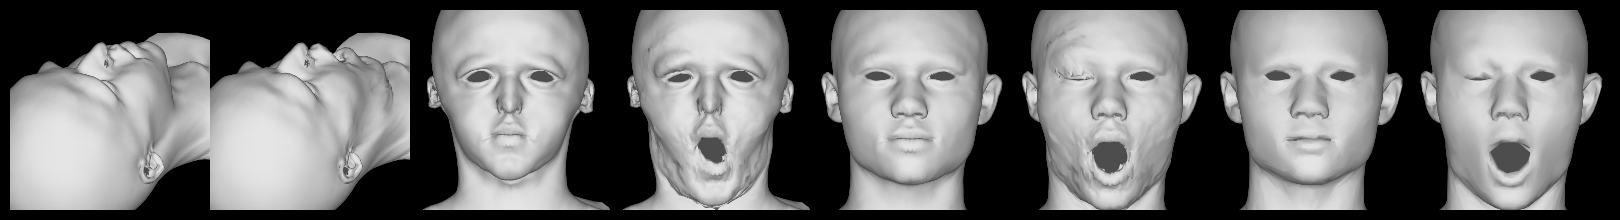

In [215]:
# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)
plot_mesh_gouraud(v_list, f_list, 
                  # Cs=vn_list, is_color=True, 
                  rot_list=rot_list, size=SIZE, mode='shade')

In [48]:
import meshplot as mp
v_pred_vn=calc_norm(trimesh.Trimesh(vertices=v_pred[0].detach().cpu().numpy(),faces=F))[0]
# v_pred_fn = compute_face_norm(v_pred[0].detach().cpu().numpy(), F)
# v_pred_vn = compute_vert_norm(torch.tensor(F), torch.tensor(v_pred_fn)[None])[0].numpy()


V_th_vn=calc_norm(trimesh.Trimesh(vertices=V_th[0].detach().cpu().numpy(),faces=F))[0]
# V_th_fn = compute_face_norm(V_th[0].detach().cpu().numpy(), F)
# V_th_vn = compute_vert_norm(torch.tensor(F), torch.tensor(V_th_fn)[None])[0].numpy()

d = mp.subplot(v_pred[0].detach().cpu().numpy(), F, c=v_pred_vn, s=[3, 3, 0])
mp.subplot(V_th[0].detach().cpu().numpy(), F, c=V_th_vn, s=[3, 3, 1], data=d)

In [163]:
base_coord.shape

torch.Size([1, 11248, 3])

[000000] loss: 4.217e-01:   0%|          | 0/6000 [00:00<?, ?it/s]

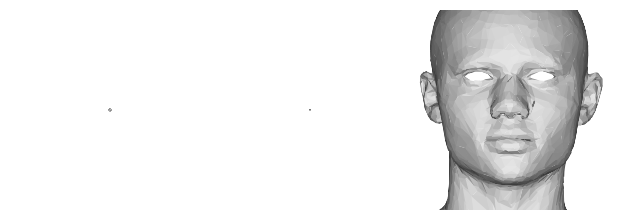

[001000] loss: 3.455e-03:  17%|█▋        | 998/6000 [00:08<00:42, 118.18it/s]

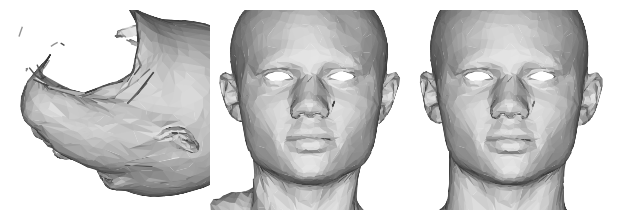

[002000] loss: 1.005e-05:  33%|███▎      | 1988/6000 [00:17<00:33, 119.65it/s]

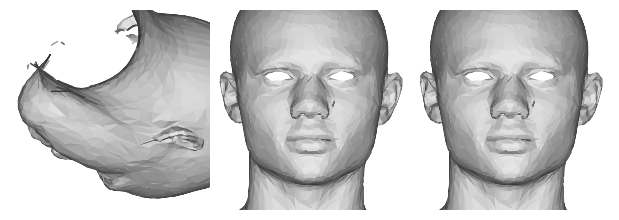

[003000] loss: 1.062e-08:  50%|████▉     | 2989/6000 [00:25<00:25, 116.56it/s]

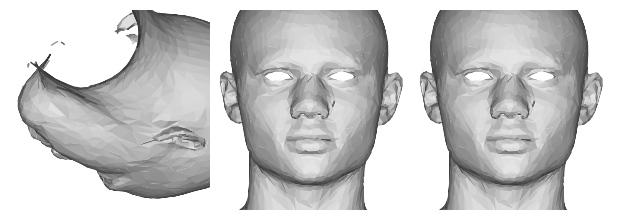

[004000] loss: 1.534e-10:  66%|██████▋   | 3989/6000 [00:34<00:17, 115.20it/s]

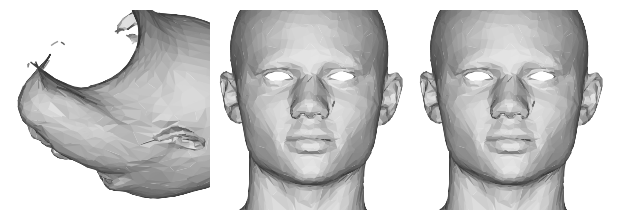

[005000] loss: 6.222e-12:  83%|████████▎ | 4991/6000 [00:43<00:08, 120.02it/s]

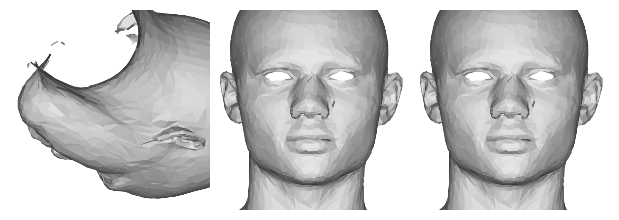

[005999] loss: 2.588e-13: 100%|██████████| 6000/6000 [00:51<00:00, 116.20it/s]


In [165]:
model.eval()

# rp = torch.randperm(base_coord.shape[1])
# rp_inv=torch.argsort(rp)

# gt_vert = torch.tensor(tmp_trimesh.vertices)[None].float()
# gt_face = torch.tensor(tmp_trimesh.faces).long()
gt_vert = base_coord[:, ict_decimate['v_idx']]
gt_face = ict_decimate['new_f']

NN = gt_vert.shape[1]
optim_coord = torch.randn(gt_vert.shape).float() *1e-3
optim_coord = optim_coord.to(device).requires_grad_(True)

lr = 2e-3
optimizer = torch.optim.Adam([optim_coord], lr=lr, betas=(0.9, 0.999))
criterion = nn.MSELoss()

batch_size = 1

pbar = tqdm(range(6_000))
for i in pbar:

    optim_coord_ = torch.cat([optim_coord, gt_vert.to(device)], dim=-1)
    
    w1 = model(optim_coord_, ID_code[0][None,None].to(device)).reshape(batch_size,NN,3,3)
    pred_vert = torch.einsum('bnck,bnk->bnc', w1, optim_coord)

    loss = criterion(gt_vert.to(device), pred_vert)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #new_disp1 = torch.einsum('bnck,nk->bnc', w1, torch.tensor(displacements).float()to(device) ).cpu().detach()

    pbar.set_description(f"[{i:06d}] loss: {loss.item():.3e}")
    if i % 1000 == 0:
        v_list=[ 
            optim_coord[0].detach().cpu().numpy(),
            pred_vert[0].detach().cpu().numpy(),
            gt_vert[0],
        ]
        # v_list=[ base_coord[0].detach().numpy(), id_disp[0]+base_coord[0].detach().numpy()]
        # v_list=[ v for v in v_list ]
        f_list=[ gt_faces ]*len(v_list)

        # xyz Euler angle to rotate the mesh
        rot_list=[ [0,0,0] ]*len(v_list)
        plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

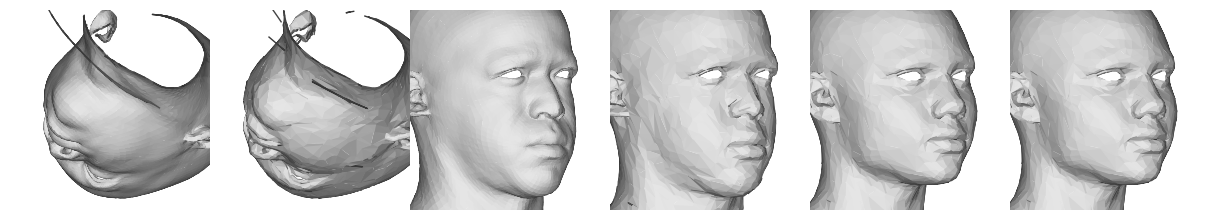

In [167]:

# v_list=[ id_vert[0], v_pred[0].detach().cpu().numpy(), V_th[0]]

v_list=[ 
    id_vert[0].detach().cpu().numpy(),
    optim_coord[0].detach().cpu().numpy(),
    id_vert[0].detach().cpu().numpy() @ R0.T,
    optim_coord[0].detach().cpu().numpy() @ R0.T,
    pred_vert[0].detach().cpu().numpy(),
    gt_vert[0].detach().cpu().numpy(),
]
# v_list=[ base_coord[0].detach().numpy(), id_disp[0]+base_coord[0].detach().numpy()]
# v_list=[ v for v in v_list ]
f_list=[ F, gt_face, F, gt_face, gt_face, gt_face ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,40,0] ]*len(v_list)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

In [16]:
from scipy.spatial import cKDTree
def map_vertices(orig_vert, deci_vert, k=1):
    """
    Get nearest neighbor vertex on original mesh
    Args:
        orig_vert (np.ndarray)
        deci_vert (np.ndarray)
    Return
        distances (np.ndarray): distance with the nearest neighbor vertex on original mesh
        vertex_map (np.ndarray): index of the nearest neighbor vertex on original mesh
    """
    tree = cKDTree(orig_vert)
    distances, vertex_map = tree.query(deci_vert, k=k)
    return distances, vertex_map

def compute_barycentric_coords(p, tri):
    """
    Compute barycentric coordinates of point p with respect to triangle tri (3x3 array)
    """
    v0, v1, v2 = tri
    v0v1 = v1 - v0
    v0v2 = v2 - v0
    v0p = p - v0
    d00 = np.dot(v0v1, v0v1)
    d01 = np.dot(v0v1, v0v2)
    d11 = np.dot(v0v2, v0v2)
    d20 = np.dot(v0p, v0v1)
    d21 = np.dot(v0p, v0v2)
    denom = d00 * d11 - d01 * d01
    v = (d11 * d20 - d01 * d21) / denom
    w = (d00 * d21 - d01 * d20) / denom
    u = 1.0 - v - w
    return np.array([u, v, w])

def project_vertices_to_barycentric(source_mesh, target_mesh, direction='both', k_neighbors=3):
    source_vertices = source_mesh.vertices
    source_normals = source_mesh.vertex_normals
    target_faces = target_mesh.faces
    target_vertices = target_mesh.vertices

    if direction == 'positive':
        directions = source_normals
    elif direction == 'negative':
        directions = -source_normals
    elif direction == 'both':
        directions = np.concatenate([source_normals, -source_normals], axis=0)
        origins = np.concatenate([source_vertices, source_vertices], axis=0)
    else:
        raise ValueError("Invalid direction")

    if direction != 'both':
        origins = source_vertices

    # Use Trimesh ray engine (ray_triangle or pyembree if installed)
    try:
        from trimesh.ray.ray_pyembree import RayMeshIntersector
        ray_intersector = RayMeshIntersector(target_mesh)
    except ImportError:
        from trimesh.ray.ray_triangle import RayMeshIntersector
        ray_intersector = RayMeshIntersector(target_mesh)

    # Ray intersection
    locations, index_ray, index_tri = ray_intersector.intersects_location(
        ray_origins=origins,
        ray_directions=directions,
        multiple_hits=False
    )

    N = source_vertices.shape[0]
    triangle_indices = -np.ones(N, dtype=int)
    bary_coords = np.full((N, 3), np.nan)

    for i, ray_idx in enumerate(index_ray):
        orig_idx = ray_idx % N
        triangle = target_faces[index_tri[i]]
        tri_coords = target_vertices[triangle]
        bc = compute_barycentric_coords(locations[i], tri_coords)
        bary_coords[orig_idx] = bc
        triangle_indices[orig_idx] = index_tri[i]

    # Fill missing values using nearest neighbors
    missing = triangle_indices == -1
    if np.any(missing):
        known_idx = np.where(~missing)[0]
        missing_idx = np.where(missing)[0]
        if len(known_idx) == 0:
            raise ValueError("No valid projections found; cannot interpolate.")
        kdtree = cKDTree(source_vertices[known_idx])
        _, nn_indices = kdtree.query(source_vertices[missing_idx], k=min(k_neighbors, len(known_idx)))
        for i, (m_idx, nn) in enumerate(zip(missing_idx, nn_indices)):
            nn = np.atleast_1d(nn)
            bary_coords[m_idx] = np.mean(bary_coords[known_idx[nn]], axis=0)
            triangle_indices[m_idx] = int(np.round(np.mean(triangle_indices[known_idx[nn]])))

    return triangle_indices, bary_coords

def barycentric_to_world_position(triangle_indices, bary_coords, vertices, faces):
    """
    Given triangle indices and barycentric coordinates, reconstruct 3D positions on the target mesh.
    
    Parameters:
    - triangle_indices: (N,) int array of triangle indices on the target mesh
    - bary_coords: (N, 3) float array of barycentric coordinates
    - target_mesh: trimesh.Trimesh object

    Returns:
    - positions: (N, 3) float array of 3D positions
    """
    N = triangle_indices.shape[0]
    positions = np.zeros((N, 3))

    for i in range(N):
        tri_idx = triangle_indices[i]
        bc = bary_coords[i]
        if tri_idx == -1 or np.any(np.isnan(bc)):
            positions[i] = np.nan
            continue
        tri = vertices[faces[tri_idx]]
        # p = u*v0 + v*v1 + w*v2
        positions[i] = bc[0] * tri[0] + bc[1] * tri[1] + bc[2] * tri[2]
    return positions


In [ ]:
def normal_projection(source_v, source_f, target_v, target_f, direction='both'):
    """
    Projects each vertex of source_mesh onto the surface of target_mesh along the normal direction.
    
    direction: 'both', 'positive', or 'negative' (controls which normal directions to test)
    """
    source_mesh = trimesh.Trimesh(vertices=source_v, faces=source_f, maintain_order=True)
    target_mesh = trimesh.Trimesh(vertices=target_v, faces=target_f, maintain_order=True)

    # Build ray engine for the target mesh
    target_scene = trimesh.Scene(target_mesh)
    ray_engine = target_scene.ray

    vertices = source_mesh.vertices
    normals = source_mesh.vertex_normals
    new_vertices = np.copy(vertices)

    if direction == 'positive':
        directions = normals
    elif direction == 'negative':
        directions = -normals
    elif direction == 'both':
        directions = np.concatenate([normals, -normals], axis=0)
        vertices = np.concatenate([vertices, source_mesh.vertices], axis=0)
    else:
        raise ValueError("Invalid direction option")

    # Ray casting
    locations, index_ray, index_tri = ray_engine.intersects_location(
        ray_origins=vertices,
        ray_directions=directions,
        multiple_hits=False
    )

    # Update only the intersected vertices
    for i, ray_idx in enumerate(index_ray):
        if direction == 'both' and ray_idx >= len(source_mesh.vertices):
            ray_idx = ray_idx - len(source_mesh.vertices)
        new_vertices[ray_idx] = locations[i]

    # Return the new mesh
    projected_mesh = source_mesh.copy()
    projected_mesh.vertices = new_vertices
    return projected_mesh


(3694, 10, 3)

In [168]:
# distances, vertex_map = map_vertices(
#     id_tmp,
#     tmp_trimesh.vertices,
#     k=4
# )
distances, vertex_map = map_vertices(
    id_vert[0].detach().cpu().numpy(),
    optim_coord[0].detach().cpu().numpy(),
    k=2
)
# tree = cKDTree(id_tmp)
# distances, vertex_map = tree.query(tmp_trimesh.vertices, k=2)

# source_mesh = trimesh.Trimesh(vertices=tmp_trimesh.vertices, faces=tmp_trimesh.faces)
# target_mesh = trimesh.Trimesh(vertices=id_tmp, faces=F)
# triangle_indices, bary_coords = project_vertices_to_barycentric(source_mesh, target_mesh, direction='both', k_neighbors=3)
# # print(vertex_map.shape)
# val = barycentric_to_world_position(triangle_indices, bary_coords, vertices=id_tmp, faces=F)
# # print((1-distances) /((1-distances).sum(1, keepdims=True)))


In [ ]:
val.shape

(3694,)

/tmp/ipykernel_7250/877616289.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  in_coord = torch.tensor(id_vert).float()


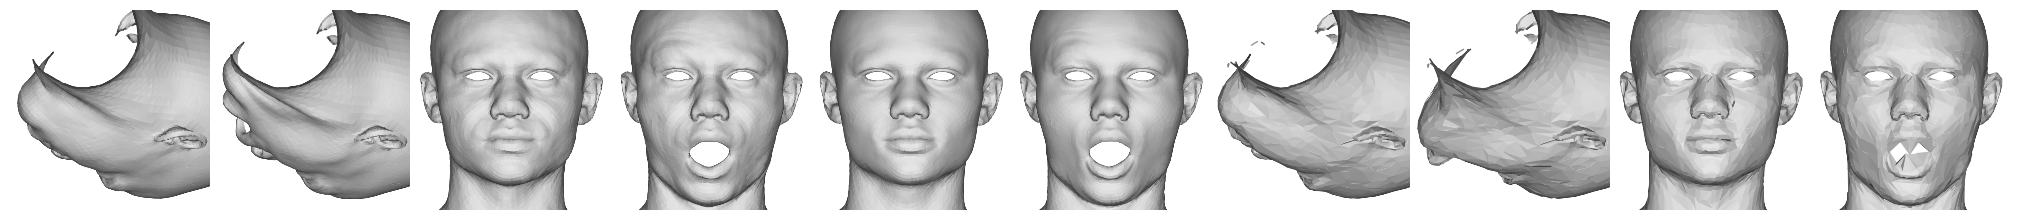

In [170]:
model.eval()
# base_coord = torch.tensor(ict.neutral_verts)[None].float()

# displacements = ict.get_exp_disp(np.random.rand(1,53)) # [1, N, 3]
blendshapes = ict.exp_basis[:,:11248]
BS1 = 26
BS2 = 5
displacements = blendshapes[BS1]+blendshapes[BS2]
displacements = displacements @ R0

base_coord = torch.tensor(id_tmp)[None].float()
# tgt_vert = torch.tensor(tmp_trimesh.vertices)[None].float()
tgt_vert = gt_vert

in_coord = torch.tensor(id_vert).float()
rp = torch.randperm(in_coord.shape[1])
rp_inv=torch.argsort(rp)

batch_size=2
N = in_coord.shape[1]

# V_th1 = in_coord.repeat(batch_size, 1, 1)
# V_th1 = V_th1[:, rp]

in_coord_ = torch.cat([in_coord.to(device), base_coord.to(device).repeat(batch_size, 1, 1)], dim=-1)
w1 = model(in_coord_, ID_code[:, None].to(device)).reshape(batch_size,N,3,3)


v_trns1 = torch.einsum('bnck,bnk->bnc', w1, in_coord.to(device)).cpu().detach().numpy()

new_disp1 = torch.einsum('bnck,nk->bnc', w1, torch.tensor(displacements).float().to(device) ).cpu().detach()


M=vertex_map.shape[0]
in_mapped = in_coord[:, vertex_map].mean(-2)
base_mapped = base_coord[:,vertex_map].mean(-2).repeat(batch_size, 1, 1)
in_mapped_ = torch.cat([in_mapped.to(device), base_mapped.to(device)], dim=-1)

w2 = model(in_mapped_, ID_code[:, None].to(device)).reshape(batch_size,M,3,3)

displacements_mapped = displacements[vertex_map].mean(-2)
new_disp2 = torch.einsum('bnck,nk->bnc', w2, torch.tensor(displacements_mapped).float().to(device) ).cpu().detach()



v_list=[ 
    in_coord[0].detach().numpy(),
    # id_disp[0]+in_coord[0].detach().numpy(),
    displacements+in_coord[0].detach().numpy(),
    v_trns1[0],
    (new_disp1+v_trns1)[0],
    base_coord[0],
    (new_disp1+base_coord)[0],
    optim_coord[0].detach().cpu(),
    (new_disp2+optim_coord.detach().cpu())[0],
    tgt_vert[0],
    (new_disp2+tgt_vert)[0],
]
# v_list=[ in_coord[0].detach().numpy(), id_disp[0]+in_coord[0].detach().numpy()]
v_list=[ v for v in v_list ]
f_list=[ F, F, F, F, F, F, gt_face, gt_face, gt_face, gt_face ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

In [147]:
base_coord[:,vertex_map].shape

torch.Size([1, 3694, 4, 3])

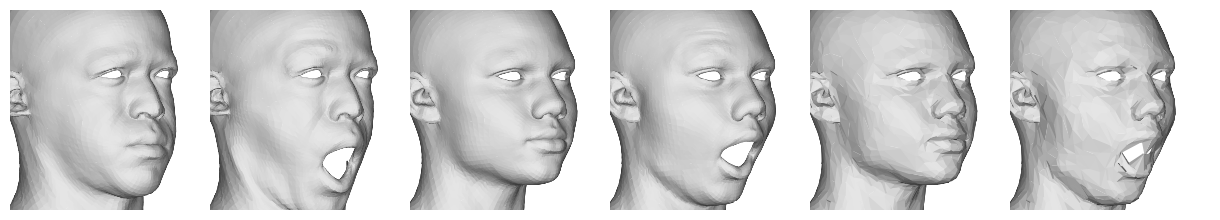

In [173]:
blendshapes = ict.exp_basis[:,:11248]
BS1 = 26
BS2 = 5
displacements = blendshapes[BS1]+blendshapes[BS2]
displacements = displacements

v_list=[ 
    in_coord[0].detach().numpy() @ R0.T,
    (displacements@R0+in_coord[0].detach().numpy())  @ R0.T,
    base_coord[0],
    (new_disp1+base_coord)[0],
    tgt_vert[0],
    (new_disp2+tgt_vert)[0],
]
# v_list=[ in_coord[0].detach().numpy(), id_disp[0]+in_coord[0].detach().numpy()]
v_list=[ v for v in v_list ]
f_list=[ F, F, F, F, gt_face, gt_face ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')